In [195]:
import csv
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [196]:
class Price:
    def __init__(self, line):
        self.timestamp = datetime.strptime(line[0], '%Y년 %m월 %d일')
        self.close = float(line[1].replace(',',''))
        self.open = float(line[2].replace(',',''))
        self.high = float(line[3].replace(',',''))
        self.low = float(line[4].replace(',',''))

    def __str__(self):
        return f"{self.timestamp} close:{self.close} open:{self.open} high:{self.high} low:{self.low}"

In [254]:
class Account:
    def __init__(self, initKrw, slippage):
        self.krw = initKrw
        self.slippage = slippage
        self.coin = 0.0
        self.avgPrice = 0.0
    
    def __str__(self):
        return f"krw:{self.krw:,.2f}, coin:{self.coin:,.3f}, avgPrice:{self.avgPrice:,.2f}"
    
    def GetBalance(self, price):
        return self.krw + self.coin * price
    
    def BuyWithKrw(self, krwAmount, coinPrice):
        self.krw -= krwAmount
        coinAdded = (krwAmount / coinPrice) * (1.0 - self.slippage)
        self.avgPrice = (self.avgPrice * self.coin + krwAmount) / (self.coin + coinAdded)
        self.coin += coinAdded
        
        if self.krw < 0.0:
            print("krw Error!!")
    
    def SellWithKrw(self, krwAmount, coinPrice):
        self.krw += krwAmount * (1.0 - self.slippage)
        self.coin -= krwAmount / coinPrice
        
        if self.coin < 0.0:
            print("coin Error!!")
            
    def BuyWithCoin(self, coinAmount, coinPrice):
        krwConsumed = coinAmount * coinPrice
        self.krw -= krwConsumed
        self.avgPrice = (self.avgPrice * self.coin + krwConsumed) / (self.coin + coinAmount)
        self.coin += coinAmount * (1.0 - self.slippage)
    
        if self.krw < 0.0:
            print("krw Error!!")

    def SellWithCoin(self, coinAmount, coinPrice):
        self.krw += coinAmount * coinPrice * (1.0 - self.slippage)
        self.coin -= coinAmount
        
        if self.coin < 0.0:
            print("coin Error!!")

In [211]:
#f = open('bitcoin_price.csv','r') #https://kr.investing.com/crypto/bitcoin/historical-data
f = open('ethereum_price.csv','r') #https://kr.investing.com/crypto/bitcoin/historical-data
rdr = csv.reader(f)

data = []
for num, line in enumerate(rdr):
    if num <= 3:
        print(line)
    if num == 0:
        continue
    data.append(Price(line))


['\ufeff"날짜"', '종가', '오픈', '고가', '저가', '거래량', '변동 %']
['2016년 03월 10일', '11.75', '11.20', '11.85', '11.07', '0.00K', '4.91%']
['2016년 03월 11일', '11.95', '11.75', '11.95', '11.75', '0.18K', '1.70%']
['2016년 03월 12일', '12.92', '11.95', '13.45', '11.95', '0.83K', '8.12%']


In [212]:
def simpleInfiniteBuy(initBalance, fraction, profitRate, slippage=0.001, fromYear=2012, toYear=2022):
    acc = Account(initBalance, slippage)

    unit = initBalance / fraction
    numProfit = 0
    numFail = 0
    days = 0

    for d in data:    
        if d.timestamp.year < fromYear or d.timestamp.year > toYear:
            continue
            
        days += 1
        
        if acc.krw <= 1E-6 :
            numFail += 1
            acc.SellWithCoin(acc.coin, d.open)            
            unit = acc.krw / fraction

        acc.BuyWithKrw(min(unit, acc.krw), d.open)

        profitPrice = acc.avgPrice * (1.0 + profitRate)
        if profitPrice <= d.high:
            numProfit += 1
            acc.SellWithCoin(acc.coin, profitPrice)
            unit = acc.krw / fraction
    
    winRate = numProfit / (numProfit + numFail)
    return winRate, acc.GetBalance(d.close), days, numProfit + numFail

In [325]:
def smartInfiniteBuy(initBalance, fraction, profitRate, slippage=0.001, fromYear=2012, toYear=2022, debug=False):
    acc = Account(initBalance, slippage)

    unit = initBalance / fraction
    numProfit = 0
    numFail = 0
    days = 0

    for d in data:    
        if d.timestamp.year < fromYear or d.timestamp.year > toYear:
            continue
                    
        if acc.krw <= 1E-6:
            if debug:print("fail!!")
            numFail += 1
            acc.SellWithCoin(acc.coin, d.open)            
            unit = acc.krw / fraction

        if acc.coin == 0.0 \
            or acc.avgPrice * 0.95 > d.open:
            acc.BuyWithKrw(min(unit, acc.krw), d.open)

        profitPrice = acc.avgPrice * (1.0 + profitRate)
        if profitPrice <= d.high:
            if debug:print("succ!!")
            numProfit += 1
            acc.SellWithCoin(acc.coin, profitPrice)
            unit = acc.krw / fraction
    
        days += 1
        
        if debug:print(f"{d} balance:{acc.GetBalance(d.close):.2f} {acc}\n")
            
    winRate = numProfit / (numProfit + numFail)
    return winRate, acc.GetBalance(d.close), days, numProfit + numFail

In [335]:
fractions = []
winRates = []
balances = []
days = []


#winRate, balance, days, num = simpleInfiniteBuy(100.0, fraction = 30, profitRate = 0.05, slippage=0.001, fromYear=2017, toYear=2022)
#print(f"winRate {winRate:.3f}, balance {balance:.1f}, {days} 일동안 {num}번 정산")

#for rate in range(1, 11):
    #winRate, balance, days, num = smartInfiniteBuy(100.0, fraction = 30, profitRate = rate/100, slippage=0.001, fromYear=2017, toYear=2022, debug=False)
    #print(f"winRate {winRate:.3f}, balance {balance:.1f}, {days} 일동안 {num}번 정산")

winRate, balance, days, num = smartInfiniteBuy(10000, fraction = 40, profitRate = 0.05, slippage=0.001, fromYear=2016, toYear=2022, debug=False)
print(f"winRate {winRate:.3f}, balance {balance:.1f}, {days} 일동안 {num}번 정산")

#    fractions.append(fraction)
#    winRates.append(winRate)
#    balances.append(balance)
#    days.append(day)
    

winRate 0.986, balance 11093.6, 2182 일동안 362번 정산


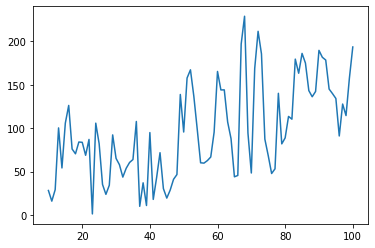

In [131]:
plt.plot(fractions, balances)